# Model explanation and feature selection

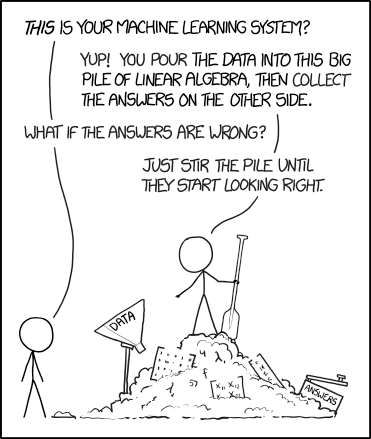

This lecture is one of the most important in the course.

According to [Towards A Rigorous Science of Interpretable Machine Learning, 2017](https://arxiv.org/abs/1702.08608) interpretability of the results is important, as it allows to estimate:
- Fairness: See my post “What does it mean for a model to be fair”
- Privacy: Ensuring that sensitive information cannot be disclosed by the model. e.g. being able to guess sensitive information but submitting specific examples to the model.
- Robustness: Changes in the input lead to “proportional changes” (yes, I know it’s is a vague definition. I promise to clarify that in the future) in the outcome/predictions.
- Causality: Only causal relationships are picked up. This means, for instance, that we don’t predict the sex of a baby based on the stock price of NYSE, for instance.
- Trust: Doshi-Velez and Kim talk about Trust since things are most trusty when you understand them. This is especially important because, in my opinion, it can happen that people would tend to grant more intelligence to systems that behave in ways they don’t understand.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re

from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR

from matplotlib import pyplot as plt
import seaborn as sns
#until install rdkit
#from rdkit.Chem import Descriptors, rdMolDescriptors
#from feature_importance_utils import moltosvg

from IPython.display import SVG, display, Markdown, HTML, display_html
from feature_importance_utils import rfr_model, rfc_model, add_split_screen

import eli5
from eli5.sklearn import PermutationImportance, explain_weights_sklearn
from eli5.formatters import format_as_html

import shap
shap.initjs()

import lime
import lime.lime_tabular

from interpret.ext.blackbox import MimicExplainer
from interpret.ext.glassbox import LinearExplainableModel

RDKit WARNING: [11:19:50] Enabling RDKit 2019.09.1 jupyter extensions


Could not import lightgbm, required if using LGBMExplainableModel


In [2]:
import json
with open('../../course_config.json') as json_file:
    CONFIG = json.load(json_file)

In [3]:
import os, sys
sys.path.append(os.path.abspath(CONFIG['utilities_path']))
from rf_utils import get_mol_data
from feature_importance_utils import rfr_model, rfc_model

### Picking up where we left

We left our Random Forest lecture on the stage of feature importance. Let's refresh our final result:

In [4]:
#the following part is a copy-paste of the code we studied in the previous lecture
opt_df = pd.read_csv(CONFIG['dataset_path']+'DB for chromophore_Sci_Data_rev02.csv', index_col=0)
chrom_df = opt_df[opt_df['Chromophore'] == opt_df['Chromophore'].value_counts().keys()[0]]
chrom_df = chrom_df[['Solvent', 'Absorption max (nm)']][1:].reset_index(drop=True)
df_dict = {}
for i, solv in enumerate(chrom_df['Solvent']):
    df_dict[i] = get_mol_data(Chem.MolFromSmiles(solv))
chrom_df = pd.concat([chrom_df, pd.DataFrame.from_dict(df_dict, orient='index')], axis=1)
y = chrom_df['Absorption max (nm)']
X = chrom_df.drop(['Solvent', 'Absorption max (nm)'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
model, params, scores = rfr_model(X_train, y_train)
print(params, scores)

{'max_depth': 10, 'n_estimators': 75} 3455.521291734514


In [6]:
rf = model.fit(X_train, y_train)
rf_predict = rf.predict(X_test)
mean_squared_error(y_test, rf_predict)

3040.2056087178307

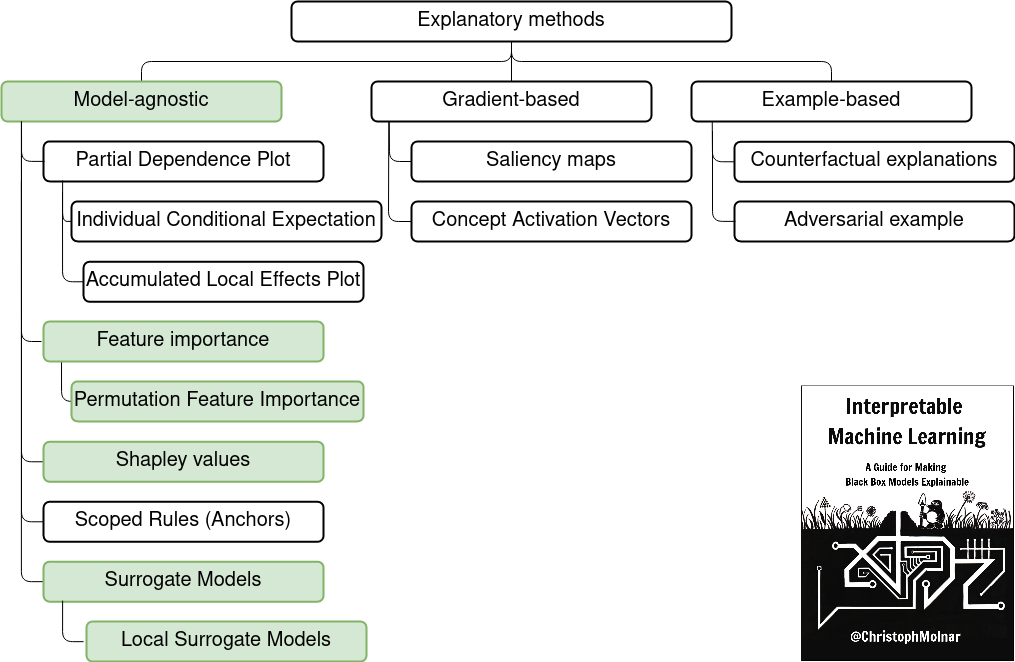

There are several method used for model explainability. Most popular are model-agnostic, as they don't rely on any particularity of the model to interpret, thus this method is highly flexible. We can interpretate any ML model with such methods.
<br>
Gradient-based methods rely on backpropagation and gradient descent training data. Can't be used for any model, but is useful for neural networks.
<br>
Example-based methods explain models by selecting parts of data from datasets. Used in computer vision and NLP
<br>
We'll study built-in sklearn feature importance, permutation importance. We'll use SHAP library for studying Shapley values, LIME for Local Surrogate Models and interpret for Global Surrogate Models.

### Feature importance, engineering, selection

When you build a forest of decision trees, some feature impact the final result and accuracy much higher than other. This is called <b>feature importance</b> -- more important feature have bigger impact. If a feature is important, then when missing, the accuracy of the model would decrease. This method is called Mean Decrease Accuracy.
<br>Let's plot our feature importance histogram:

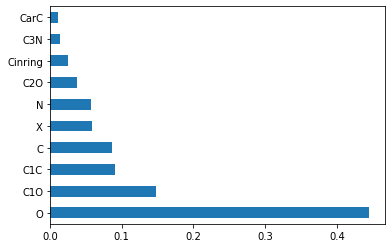

In [7]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

We've plotted our top10 most important features. The same we will do for the least valuable columns in the feature selection section. 
<br>One may notice, that among most important features are 4 O-connected, 2 N-connected and some X element. Both O and N elements are polar. There is a parameter we've already used earlier - TPSA. Topological Polar Surface Area is basically surface sum over all polar atoms or molecules. [*More info*](https://www.sciencedirect.com/topics/chemistry/polar-surface-area)
<br>Let's see, how introducing TPSA feature will affect our RF model and feature importance:

In [8]:
df_dict = {}
for i, solv in enumerate(chrom_df['Solvent']):
    mol_dict = {}
    mol_dict['TPSA'] = Descriptors.TPSA(Chem.MolFromSmiles(solv))
    df_dict[i] = mol_dict
chrom_df = pd.concat([chrom_df, pd.DataFrame.from_dict(df_dict, orient='index')], axis=1)
y = chrom_df['Absorption max (nm)']
X = chrom_df.drop(['Solvent', 'Absorption max (nm)'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model, params, scores = rfr_model(X_train, y_train)
print(params, scores)

{'max_depth': 6, 'n_estimators': 75} 2861.3358791956894


In [9]:
rf = model.fit(X_train, y_train)
rf_predict = model.fit(X_train, y_train).predict(X_test)
mean_squared_error(y_test, rf_predict)

2175.441630505501

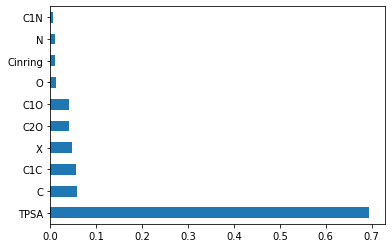

In [10]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

This is actually quite cool! We can see that not only did we significantly decreased the mse metric, but we've found a feature that is even more important than `O` feature. Also, due to less `max_depth` our model is more robust.
<br>Another feature we can try is logP - partition coefficent, that can be used as hydrophobic constant.

In [11]:
df_dict = {}
for i, solv in enumerate(chrom_df['Solvent']):
    mol_dict = {}
    mol_dict['logP'] = Descriptors.MolLogP(Chem.MolFromSmiles(solv))
    df_dict[i] = mol_dict
chrom_df = pd.concat([chrom_df, pd.DataFrame.from_dict(df_dict, orient='index')], axis=1)
y = chrom_df['Absorption max (nm)']
X = chrom_df.drop(['Solvent', 'Absorption max (nm)'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model, params, scores = rfr_model(X_train, y_train)
print(params, scores)

{'max_depth': 7, 'n_estimators': 75} 2865.058699498983


In [12]:
rf = model.fit(X_train, y_train)
rf_predict = model.fit(X_train, y_train).predict(X_test)
mean_squared_error(y_test, rf_predict)

2046.5856888136716

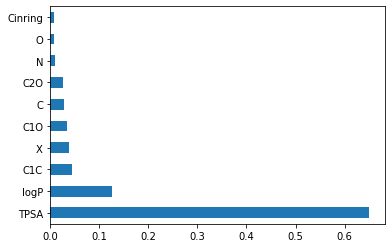

In [13]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

As you can see, the new logP feature made it to top2 features not taking much importance from the TPSA.

Let's take a look if the new features are as effective for our classification problem

In [14]:
cl_df = pd.DataFrame()
cl_df['Solvent'] = opt_df[opt_df['Solvent'] != 'gas']['Solvent'].unique()
cl_df['target'] = 0 
cl_df.loc[cl_df['Solvent'].isin(list(chrom_df['Solvent'].unique())), 'target'] = 1
df_dict = {}
for i, solv in enumerate(cl_df['Solvent']):
    df_dict[i] = get_mol_data(Chem.MolFromSmiles(solv))
    df_dict[i]['TPSA'] = Descriptors.TPSA(Chem.MolFromSmiles(solv))
    df_dict[i]['logP'] = Descriptors.MolLogP(Chem.MolFromSmiles(solv))
cl_df = pd.concat([cl_df, pd.DataFrame.from_dict(df_dict, orient='index')], axis=1)
y = cl_df['target']
X = cl_df.drop(['Solvent', 'target'], axis=1)     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [15]:
model, params, scores = rfc_model(X_train, y_train)
print(params, scores)

{'max_depth': 6, 'max_features': 'log2', 'n_estimators': 10} 0.9809679241729959


In [16]:
rfc = model.fit(X_train, y_train)
rf_predict = rfc.predict(X_test)
accuracy_score(y_test, rf_predict)

0.9841269841269841

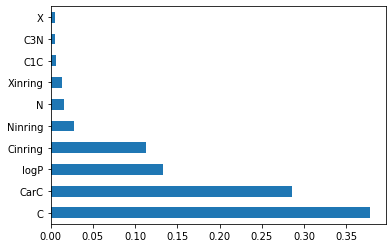

In [17]:
feature_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

A nice illustration, that shows how good regression features might not suit classification purposes. Let's drop non-relevant features and try some others - in our case more `C` and `ring` orientated

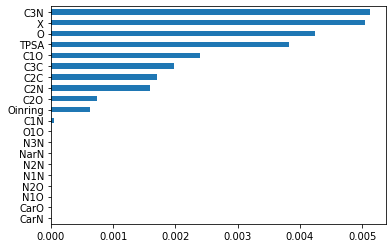

In [18]:
feature_importances.nsmallest(20).plot(kind='barh')
plt.show()

In [19]:
len(feature_importances)

28

You may notice the values of several features in 0. This happens if the values of a selected feature are either the same (in our case 0) within most part or even the whole range of samples. In our example doesn't make much sense to keep features, which importance is less than 1%:

In [20]:
upd_features = list(feature_importances[feature_importances > 0.01].keys())
upd_features

['C', 'N', 'Cinring', 'Ninring', 'Xinring', 'CarC', 'logP']

In [21]:
cl_df = cl_df[upd_features + ['Solvent', 'target']]

We'll introduce a number of new properties:
- CalcFractionCSP3 -- the fraction of C atoms that are SP3 hybridized
- CalcNumAromaticRings and CalcNumAliphaticRings -- number of aromatic/aliphatic rings respectfully
- CalcNumRotatableBonds -- number of rotatable bonds
- CalcPBF -- a metric to characterize the 3-dimensionality of molecules, according to [Plane of Best Fit: A Novel Method to Characterize the Three-Dimensionality of Molecules](https://pubs.acs.org/doi/10.1021/ci300293f)

In [22]:
df_dict = {}
for i, solv in enumerate(cl_df['Solvent']):
    df_dict[i] = {}
    df_dict[i]['CalcFractionCSP3'] = rdMolDescriptors.CalcFractionCSP3(Chem.MolFromSmiles(solv))
    df_dict[i]['CalcNumAromaticRings'] = rdMolDescriptors.CalcNumAromaticRings(Chem.MolFromSmiles(solv))
    df_dict[i]['CalcNumAliphaticRings'] = rdMolDescriptors.CalcNumAliphaticRings(Chem.MolFromSmiles(solv))
    df_dict[i]['CalcNumRotatableBonds'] = rdMolDescriptors.CalcNumRotatableBonds(Chem.MolFromSmiles(solv))
    #if CalcPBF is in the rdkit version
    #df_dict[i]['CalcPBF'] = rdMolDescriptors.CalcPBF(Chem.MolFromSmiles(solv))
cl_df = pd.concat([cl_df, pd.DataFrame.from_dict(df_dict, orient='index')], axis=1)

In [23]:
y = cl_df['target']
X = cl_df.drop(['Solvent','target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
rf_model, params, scores = rfc_model(X_train, y_train)
print(params, scores)

{'max_depth': 7, 'max_features': 'auto', 'n_estimators': 10} 0.9843198794802586


In [24]:
rfc = rf_model.fit(X_train, y_train)
rf_predict = rfc.predict(X_test)
accuracy_score(y_test, rf_predict)

0.9841269841269841

In [25]:
feature_importances = pd.Series(rfc.feature_importances_, index=X.columns)
featfig = plt.figure(figsize=(6,4))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(feature_importances.nlargest(15).sort_values().keys(), 
            np.array(feature_importances.nlargest(15).sort_values()))
featax.set_xlabel('Relative Feature Importance')
plt.tight_layout()
plt.close()

In [26]:
len(feature_importances)

11

Though, we've sacrificed a bit of accuracy, our RF model is now more robust and scalable for new features.

### Permutation importance

How can we evaluate a model without some of the features? Most models cannot natively handle missing data — they deal with floats, so there is also permutation importance. A feature is important if permuting its values increases the model error — because the model relied on the feature for the prediction. In the same way, a feature is unimportant if permuting its values keeps the model error unchanged — because the model ignored the feature for the prediction.

One of the ways to measure feature importance is to remove it entirely, train the classifier without that feature and see how doing so affects the score. However, this approach requires re-training of the classifier for each feature which is computationally expensive. The way around it is removing the feature under question from the validation set only, and computing the score for the validation set without that feature. As the trained classifier still expects to have this feature available, instead of removing the feature it can be replaced with random noise from the same distribution, as initial feature values. The easiest way to get such distribution is simply shuffling (or permuting) original feature values. And this is exactly how the permutation importance is implemented. The feature is still there for the classifier, but it does not contain any useful information.

<br> For each feature we:
1. Shuffle values in the provided dataset
2. Generate predictions using the model on the modified dataset
3. Compute predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
4. Undo the shuffle and return the data to the original order. Compare the impact on accuracy of shuffling each feature individually.

#### sklearn.permutation_importance vs eli5

Let's start with [sklearn permutation importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) and eli5(Explain like I’m 5) [library](https://github.com/TeamHG-Memex/eli5)::

In [27]:
perm_importance = permutation_importance(rfc, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
permfeatfig = plt.figure(figsize=(6,4))
featax = permfeatfig.add_subplot(1, 1, 1)
featax.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
featax.set_xlabel('Relative Feature Importance')
plt.tight_layout()
plt.close()

In [28]:
def return_perm_html(model, X_test, y_test):
    perm = PermutationImportance(model, random_state=42).fit(X_test, y_test)
    eli5_html = format_as_html(eli5.explain_weights_sklearn(perm, feature_names = X_test.columns.tolist()))
    table_pattern = re.compile("<table(.|\n)+<\/table>")
    return table_pattern.search(eli5_html)[0]


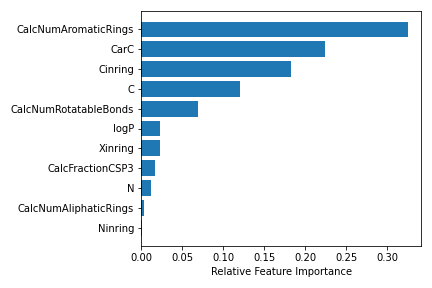
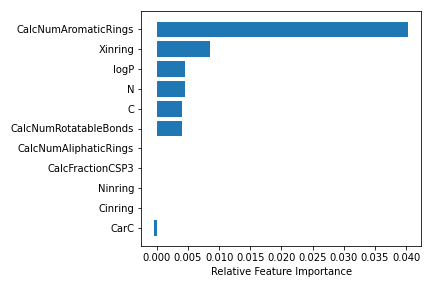

In [29]:
add_split_screen(fig1=featfig, 
                 fig2=permfeatfig, 
                 html1=return_perm_html(rf_model, X_test, y_test), iwidth='1000px')

Another interesting result. It seems like the feature `CalcNumRotatableBonds`, ranked quite low according to sklearn built-in feature importance is one of the highest.The `CarC` and `logP` feature, on the other hand, lost quite a lot.

#### LogisticRegression built-in feature_importance vs eli5

Feature importance should be used for other classification methods as well. Let's take a look at feature importance for logistic regression model:

In [30]:
lr_model = LogisticRegression(class_weight="balanced",random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

lr = lr_model.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
accuracy_score(y_test, lr_predict)

0.9795918367346939

In [31]:
feature_importance = abs(lr.coef_[0])
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(6,4))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
plt.tight_layout()
plt.close()


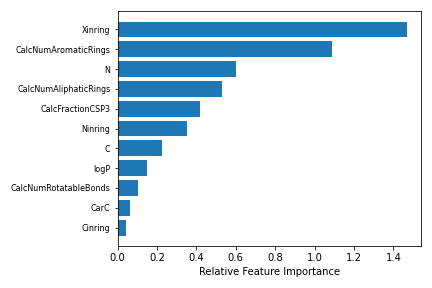

In [32]:
add_split_screen(fig1=featfig, html1=return_perm_html(lr_model, X_test, y_test), iwidth='800px')

In [33]:
#to do KNN

### Shapley values: SHAP - SHapley Additive exPlanations

Shapley values calculates each feature’s marginal impact forcing the prediction to move away from the mean value -- the baseline. The marginal contribution is calculated by computing the predicted value with and without the feature value currently being considered and take the difference to get the marginal contribution (similar to permutation). The Shapley value is then calculated by averaging the marginal contribution of the feature value across all such possible feature subsets within the feature set where the feature participates. The contribution of a feature is estimated as the difference between the actual prediction and the mean prediction.
<br>Shapley values calculation require a lot of computing time. [SHAP](https://github.com/slundberg/shap) is a Python library turning Shapley values method into an optimization problem and hence is an approximation. The results of SHAP are sparse (many Shapley values are estimated to be zero), which is the biggest difference from the classic Shapley values.

The biggest peculiarity of a Shapley summary plot is the display of positive and negative relationships of the predictors with the target variable.

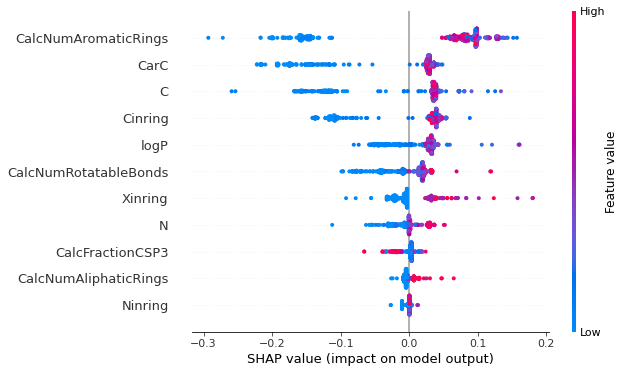

In [34]:
shap_explainer = shap.TreeExplainer(rfc)
shap_values = shap_explainer.shap_values(X_test)

# shap_values[0] are explanations with respect to the negative class, 
# while shap_values[1] are explanations with respect to the positive class
shap.summary_plot(shap_values[0], X_test)

All variables are sorted in descending order. The horizontal position reflects, whether the effect of that value is associated with a higher or lower prediction. Thus, it can be seen, that high values of `C`, `CalcNumAromaticRings`, `Cinring` has low (blue) and positive impact (right part of X-axis) on the quality rating. Highly (red) negative correlation (left part of X-axis) can be seen for `N`, `CalcNumRotatableBonds` and `CalcNumAliphaticRings`. High positive correlation can be found for `CalcFractionCSP3`.
<br>It is worth noticing, that for several top features high value is found for a narrow impact. This can be understood as 'optimal' solvent molecular properties.

SHAP module also allows building dependency plots. They show the marginal effect that one or two variables have on the predicted outcome. Suppose, we'll build `CalcFractionCSP3` feature. Automatically, another variable that `CalcFractionCSP3` interacts most with is built (`logP`).

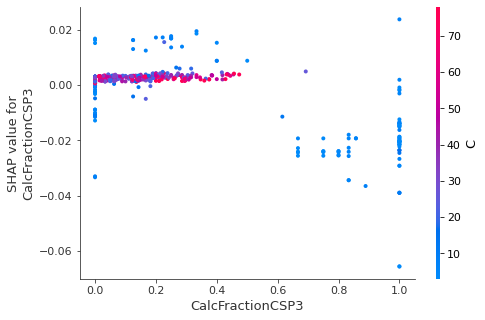

In [35]:
shap.dependence_plot("CalcFractionCSP3", shap_values[0], X_test)

### (Global) Surrogate Model: Interpret

Surrogate models attempt building a model that “mimic” the behavior of the original black-box model. The main idea is that by understanding the “mimic” model we will come to understanding othe behaviour of the original model. The process of training a model includes:
    
   1. Running model M1 to get predictions for the training dataset X and generate ŷ
   2. Generate new datasets using X and replacing the label column y with predictions column ŷ
   3. Select an interpretable model to be the surrogate model. Options: Linear Models, Logistic Regression, Decision Trees, Naïve Bayes, or KNN.
   4. Train the interpretable model on the new dataset (target -- ŷ)

To understand how well your surrogate model mimics the original R2 metric is used. We will use [interpret](https://github.com/interpretml/interpret) library to look at a surrogate model.

In [36]:
interpret_explainer = MimicExplainer(rf_model,
                           X_train,
                           LinearExplainableModel,
                           augment_data=False,
                           features=X_train.columns)
global_explanation = interpret_explainer.explain_global(X_test)
global_explanation.visualize()

## Prediction explanation

Using eli5 library we can see the explaination of a specific prediction:

In [37]:
i = 168
#juiciest samples:
#36, 84, 102, 122, 158, 168, 187, 190

In [38]:
CSS = """
.output {
flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))
print('RF model:')
display(eli5.show_prediction(rf_model, X_test.iloc[i], feature_names=X_test.columns.tolist(), show_feature_values=True))
print('LR model:')
display(eli5.show_prediction(lr_model, X_test.iloc[i], feature_names=X_test.columns.tolist(), show_feature_values=True))

RF model:


LR model:


In [39]:
cl_df.describe().loc[['mean']]

C         N    Cinring   Ninring   Xinring       CarC      logP  \
mean  32.877154  1.891386  27.113858  1.253933  0.370037  26.564794  8.461658   

        target  CalcFractionCSP3  CalcNumAromaticRings  CalcNumAliphaticRings  \
mean  0.250187          0.259998              5.267416               0.553558   

      CalcNumRotatableBonds  
mean               5.469663

In [40]:
shap.force_plot(shap_explainer.expected_value[0], shap_values[0][i,:], X_test.iloc[i,:])

It is quite impressive to analyze the collective force plot:

In [41]:
shap.force_plot(shap_explainer.expected_value[0], shap_values[0], X_test)

The prediction for this observation is 0.2 that the class is 0. It means the score for class 1 is 0.8. The base value 0.7489 is the mean value, that we'd answer not knowing any additional features. `CalcNumAromaticRings` value is 1, what is much lower than the average 5.267416, and significantly push the output value to the left. The value of `Ninring` is 1, what is lower the average 1.253933, thus a slight push to the right.

7.800582468617203

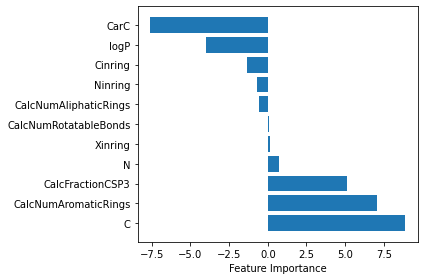

In [42]:
local_explanation = interpret_explainer.explain_local(X_test.iloc[i])
# Then, we get the actual prediction we want the explainations for
prediction_value = rf_model.predict(X_test)[i]
# Prints the names of the features along with its ranks
cols = local_explanation.get_ranked_local_names()[prediction_value]
scores = local_explanation.get_ranked_local_values()[prediction_value]


interpret_fig = plt.figure(figsize=(6,4))
interpret_ax = interpret_fig.add_subplot(1, 1, 1)
interpret_ax.barh(cols, scores)
interpret_ax.set_xlabel('Feature Importance')
plt.tight_layout()

#interpretate scores?
sum(scores)

### Local Surrogate Model: LIME -- Local Interpretable Model-agnostic Explanation

Another model we'll use for explanations - LIME. LIMEs' assumes every complex model is linear on some local scale. LIME attempts to explain model predictions by choosing most interpretable features. Though our model may be far for linear overall, in an observation location, a linear model can be useful enough. We fit a sample linear model where our prediction is the output of the complex model. The coefficients are attached if your main model is providing information.
<br>LIME belong to a more general group of surrogate models explanations, but as the model is only local to the explanation, it is local surrogate model.

In [43]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train.values,
        mode='classification',
        training_labels=y_train,
        feature_names=X_train.columns.values)

In [44]:
exp = lime_explainer.explain_instance(
    data_row = X_test.iloc[i].values,
    predict_fn = rf_model.predict_proba)
exp.show_in_notebook()

## Feature Selection

Not all features are equally important, as we figured out. Creating, engineering, calculating metrics/importances and dropping features is an iterative process. This procedure is repeated recursively until the desired number of features to select or the necessary score is eventually reached. We've studied creating, engineering, calculating metrics and feature importances. We already have a 1-2 features we consider dropping. A good practice is to check if some metrics are highly correlated.

<AxesSubplot:>

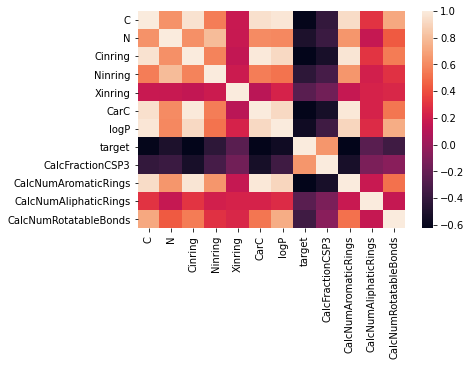

In [45]:
sns.heatmap(cl_df.corr())

No suprise we find correlations among features `Cinring`-`CarC`-`CalcNumAromaticRings`. Some of them needs to be cleaned

There are built-in feature_selection option in sklearn: `RFE`, `RFECV`

In [46]:
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)
selector.support_

selector.ranking_

array([1, 4, 5, 3, 6, 1, 1, 1, 1, 2, 7])

In [47]:
estimator = SVR(kernel="linear")
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X, y)
selector.support_

selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

# Appendix 

Like many other permutation-based interpretation methods, the Shapley value method suffers from inclusion of unrealistic data instances when features are correlated.

The main advantage of interpret is its flexibility and intuitively. R2 is a relatively good metric to measure capturability of the original model. The main drawback is that there is always a chance the surrogate model uses the features differently than the original model.

LIME is simple and time-effective. Its' main drawback is the assumption of linearity at locality level which may not be true. Recently LIME method has been under critic (see References)

Advantages of permutation:
- Importance is very easy to undestand since it related directly to the error rate introduced by no paying attention to the feature
- Automatically takes into account all interactions with other features, since permutations will also destroy the interaction effect. However, this will also mean that the degradation in performance due to losing such interaction will be accounted multiple times

Disadvantages:
- Сalculated weights may start to diverge when your model evolves or is retrained.
- You need access to the actual outcome target.
- The permutation feature importance measure depends on shuffling the feature, which adds randomness and, when features are correlated, the permutation feature importance measure can be biased by unrealistic data instances.
- Average values in the importance measure may not be easy to interpret: If a feature has medium permutation importance, that could mean it has a large effect for a few predictions, but no effect in general, or a medium effect for all predictions.
- Might be misleading, dealing with correlated features

# Reference

### Literature
- [Towards A Rigorous Science of Interpretable Machine Learning, 2017](https://arxiv.org/abs/1702.08608)
- [Visualizing the Feature Importance for Black Box Models, 2018](https://arxiv.org/abs/1804.06620)
- [On the Convergence Theory of Gradient-Based Model-Agnostic Meta-Learning Algorithms, 2019](https://arxiv.org/abs/1908.10400)
- [Interpreting Interpretability: Understanding Data Scientists’ Use of Interpretability Tools for Machine Learning, 2020](http://www-personal.umich.edu/~harmank/Papers/CHI2020_Interpretability.pdf)
- [Model-agnostic Feature Importance and Effects with Dependent Features -- A Conditional Subgroup Approach, 2020](https://arxiv.org/abs/2006.04628)
- [Interpretable Machine Learning - Christoph Molnar, 2021](https://christophm.github.io/interpretable-ml-book/)
- Set of articles dedicated to Feature Importance: https://santiagof.medium.com/

Individual Conditional Expectation:
- [Peeking Inside the Black Box: Visualizing Statistical Learning with Plots of Individual Conditional Expectation, 2013](https://arxiv.org/abs/1309.6392)

Accumulated Local Effects Plot:
- [Visualizing the Effects of Predictor Variables in Black Box Supervised Learning Models, 2016](https://arxiv.org/abs/1612.08468)

Feature Importance: 
- [A Simple and Effective Model-Based Variable Importance Measure, 2018](https://arxiv.org/abs/1805.04755)
- Permutation Feature Importance: [Conditional variable importance for random forests, 2008](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-307)
- Permutation Feature Importance: [All Models are Wrong, but Many are Useful: Learning a Variable's Importance by Studying an Entire Class of Prediction Models Simultaneously, 2019](https://arxiv.org/abs/1801.01489)
- Permutation Feature Importance: [Please Stop Permuting Features: An Explanation and Alternatives, 2019](https://arxiv.org/pdf/1905.03151.pdf)
- Impurity Feature Importance example: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html 
- Dropped Variable Importance: [Distribution-Free Predictive Inference For Regression, 2016](https://arxiv.org/abs/1604.04173)
- Permute-and-Relearn Importance: [Quantifying Uncertainty in Random Forests via ConfidenceIntervals and Hypothesis Tests, 2016](https://jmlr.org/papers/volume17/14-168/14-168.pdf)

Surrogate Models:
- [InterpretML: A Unified Framework for Machine Learning Interpretability, 2019](https://arxiv.org/abs/1909.09223)
- [Model-Agnostic Interpretability of Machine Learning, 2016](https://arxiv.org/abs/1606.05386)
- [On the Robustness of Interpretability Methods, 2018](https://arxiv.org/abs/1806.08049)
- [Fooling LIME and SHAP: Adversarial Attacks on Post hoc Explanation Methods, 2019](https://arxiv.org/abs/1911.02508)
- [A study of data and label shift in the LIME framework, 2019](https://arxiv.org/abs/1910.14421)

Anchors:
- [Anchors: High-Precision Model-Agnostic Explanations, 2018](https://homes.cs.washington.edu/~marcotcr/aaai18.pdf)

Shapley:
- Shapley, Lloyd S. "A value for n-person games." Contributions to the Theory of Games 2.28 (1953): 307-317.
- [A Unified Approach to Interpreting Model Predictions, 2017](https://arxiv.org/abs/1705.07874)
- [Explanations of model predictions with live and breakDown packages, 2018](https://arxiv.org/abs/1804.01955)
- [The many Shapley values for model explanation, 2019](https://arxiv.org/abs/1908.08474)

### Med:
- [Explainable machine-learning predictions for the prevention of hypoxaemia during surgery, 2018](https://www.nature.com/articles/s41551-018-0304-0)